# Генерация точек

Для начала необходимо сгенерировать два облака точек, которые мы постараемся разделить прямой. В первую очередь подключим библиотеки для работы с матрицами и графиками, а также функцию генерации случайного числа и для вычисления доли правильных ответов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import random
from sklearn import metrics

Теперь напишем функцию генерации облака точек с нормальным распределением с единичной матрицей ковариаций. Для этого просто вызовем функцию $multivariative\_normal$, которая есть в пакете numpy. Передавать мы будем два параметра - центр и количество точек (можно также менять матрицу ковариаций, чтобы получать различные формы облака, но оставим этот параметр фиксированным).

In [2]:
def GeneratePointCloud(mean, size):
    points = np.random.multivariate_normal(mean, np.eye(2), size)
    return points

Непосредственно сгенерируем по $500$ точек двух цветов - синего и красного. Центр синего облака пусть будет в точке $(0,0)$. А центр красного - в $(\frac{5}{2},\frac{5}{2})$.

In [3]:
points_number = 500
blue = GeneratePointCloud((0, 0), points_number)
red = GeneratePointCloud((2.5, 2.5), points_number)

Изобразим все это на плоскости. Для удобства сделаем точки прозрачными:

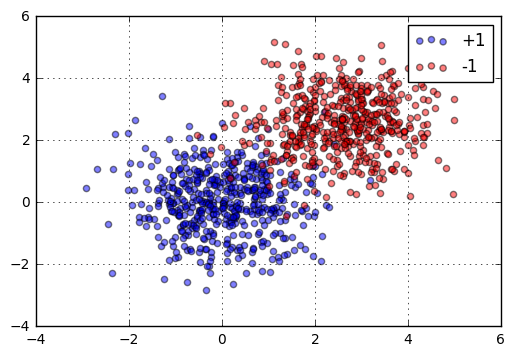

In [4]:
fig, ax = plt.subplots()

plt.scatter(blue[:, 0], blue[:, 1], c='blue', alpha=0.5, label='+1')
plt.scatter(red[:, 0], red[:, 1], c='red', alpha=0.5, label='-1')

leg = plt.legend()
ax.grid(True)
plt.show()

# Обучение

Теперь необходимо обучить линейный классификатор. Пусть разделяющая прямая имеет вид $w_1x_1 + w_2x_2 + w_0 = 0$. Обозначим $x = (x_1, x_2, 1), w = (w_1, w_2, w_0)^T$. Тогда задача минимизации среднеквадратичной ошибки имеет вид $$L(w) = \frac{1}{l} (Xw - Y)^2 \to min.$$ Здесь $X$ - матрица, строки которой суть объекты обучающей выборки, $Y$ - значения целевой функции. Получаем аналитическое решение: $$w = (X^TX)^{-1}X^TY.$$ Теперь подготовим обучающую выборку. Множество $X$ - это просто все сгенерированные точки. А множество $Y$ - это их метки классов. В нашем случае у синих точек метка $1$, а у красных $-1$.

In [5]:
X_train = np.vstack([blue, red])
Y_train = np.vstack([np.ones((points_number, 1)), -np.ones((points_number, 1))])

Создадим класс линейных классификаторов. Конструктор у него будет пустым. Функция $analytical\_fit$ принимает на вход обучающую выборку и вычисляет оптимальные параметры $w, b$ по вышеприведенным формулам. Для этого используются функции для работы с матрицами из $numpy$. Функция $predict$ принимает на вход тестовую выборку и возвращает предполагаемые классы в зависимости от того, с какой стороны от разделяющей прямой находятся точки. Оставшиеся два метода просто возвращают найденные значения коэффициентов разделяющей прямой.

In [6]:
from random import random

class LinearClassifier(object):
    def __init__(self, n, coefs):
        if coefs == 'random':
            self.coefs = np.random.rand(n + 1, 1)
        elif coefs == 'zeros':
            self.coefs = np.zeros((n + 1, 1))
    
    def get_coefs(self):
        return self.coefs[:-1]
    
    def get_intersect(self):
        return self.coefs[-1]
    
    def predict(self, X):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        Y_pred = np.dot(X, self.coefs)
        Y_pred = np.sign(Y_pred)
        return Y_pred

class AnalyticalClassifier(LinearClassifier):
    def fit(self, X_train, Y_train):
        B = np.ones((X_train.shape[0], 1))
        X = np.hstack([X_train, B])
        self.coefs = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y_train)

Теперь создадим наш классификатор и попробуем обучить его аналитически на созданной выборке. После этого посмотрим на параметры, которые получил классификатор.

In [7]:
clf = AnalyticalClassifier(2, 'random')
clf.fit(X_train, Y_train)
w_1, w_2 = clf.get_coefs()
w_0 = clf.get_intersect()

Для построения графика введем дополнительную функцию вычисления значения координаты $y$ по значению аргумента $x$.

In [8]:
def line(x):
    return - w_1 * x / w_2 - w_0 / w_2

Наконец, изобразим на плоскости множества точек и разделяющую прямую.

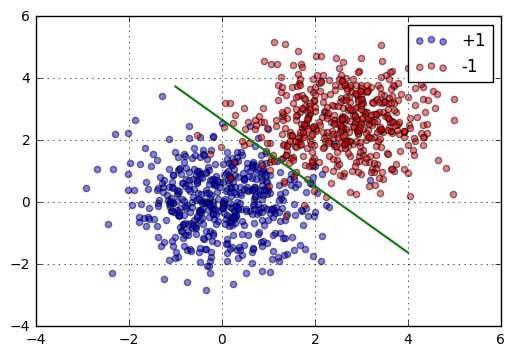

In [9]:
fig, ax = plt.subplots()

plt.scatter(blue[:, 0], blue[:, 1], c='blue', alpha=0.5, label='+1')
plt.scatter(red[:, 0], red[:, 1], c='red', alpha=0.5, label='-1')
plt.plot([-1,4], [line(-1), line(4)], c='green', lw=1.5)

leg = plt.legend()
ax.grid(True)
plt.show()

Видно, что классификация достаточно хорошая, но ее можно улучшить. Оценим сложность алгоритма. Все операции заключаются в последовательных действиях с матрицами. Т.к. $X \in M_{l \times n}$, а $Y \in M_{l \times 1}$, получаем, что $X^T$ вычисляется за $O(ln)$, умножение $X^TX$ за $O(n^2l)$, обратная матрица находится за $O(n^3)$, произведение $(X^TX)^{-1}X^T$ за время $O(n^2l)$, а последнее умножение на $Y$ - за $O(nl)$. Коэффициент $b$ находится за $O(n)$. Итого асимптотика $O(n^2l + n^3)$.

# Логистическая регрессия

Пусть $$P(y = 1 \ | \ x) = \frac{1}{1 + e^{-(wx+b)}}.$$ Это вероятность того, что выбранный объект имеет метку $1$. Отсюда $$P(y = -1 \ | \ x) = 1 - \frac{1}{1 + e^{-(wx+b)}} = \frac{e^{-(wx+b)}}{1 + e^{-(wx+b)}} = \frac{1}{1 + e^{wx+b}}.$$ Обозначим за $y_x$ класс объекта $x$ в обучающей выборке и запишем функцию правдоподобия на данной выборке, как функцию от $w, b$: $$\mathcal{f}(w, b) = \prod\limits_{x, y} P(y = y_x \ | \ x) = \prod\limits_{x, y: \ y_x = 1} P(y = 1 \ | \ x) \prod\limits_{x, y: \ y_x = -1} P(y = -1 \ | \ x) \to max.$$ Но оптимизация этой функции эквивалентна минимизации функции $-\ln{(\mathcal{f})}(w, b)$. Распишем это функцию: $$\sum\limits_{x: \ y_x = 1} \ln{(1 + e^{-(wx+b)})} \sum\limits_{x: \ y_x = -1} \ln{(1 + e^{wx+b})} = \sum\limits_{x} \ln{1 + e^{-y_x(wx+b)}} \to min.$$ Таким образом, мы доказали, что минимизация данной функции $(log-loss)$ эквивалентна максимизации правдоподобия.

# Функции эмпирического риска

Рассмотрим различные функции потерь в задаче регрессии, зависящие от отступа $M(x, y) = y(wx+b)$. Заметим, что смысл отступа следующий: если объект уверенно правильно классифицирован (т.е. далеко от разделяющей гиперплоскости), то отступ большой по модулю и положительный. Если объект уверенно классифицирован, но ошибочно, то отступ также большой по модулю и отрицательный. Если же объект классифицирован неуверенно (находится близко к разделяющей гиперплоскости), то значение отступа близко к нулю. Все функции будем рассматривать, как функции на одном объекте. Перечислим их:
1. $Q = [M < 0]$ - индикатор неправильного ответа.
2. $Q = ((wx+b) - y)^2$ - среднеквадратичная ошибка. В нашем случае $Q = (M - 1)^2$ (при обоих значениях y).
3. $Q = max(0, 1 - M)$ - метод опорных векторов.
4. $Q = \frac{1}{\ln{2}}\ln{(1 + e^{-M})}$ - логистическая регрессия.

Изобразим графики функций потерь в осях $M \times Q$.

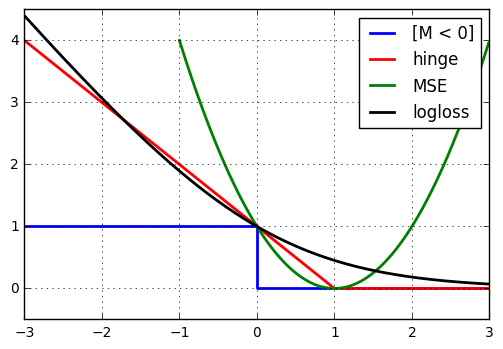

In [10]:
fig, ax = plt.subplots()

x_mse = np.arange(-1, 3, 0.01)
mse = (x_mse - 1) ** 2
x_logloss = np.arange(-3, 3, 0.01)
logloss = np.log(1 + np.e ** (-x_logloss)) / np.log(2)

plt.axis([-3, 3, -0.5, 4.5])
plt.plot([-3,0,0,3], [1,1,0,0], lw=2, c='blue', label='[M < 0]')
plt.plot([-3,1,3], [4,0,0], lw=2, c='red', label='hinge')
plt.plot(x_mse, mse, lw=2, c='green', label='MSE')
plt.plot(x_logloss, logloss, lw=2, c='black', label='logloss')

leg = plt.legend()
ax.grid(True)
plt.show()

# Градиентный спуск

Рассмотрим следующую функцию: $$f(x, y) = x^2 + 5y^2.$$
Ясно, что она имеет глобальный минимум в точке $(0, 0)$.
Можно посмотреть, как выглядит эта функция в районе минимума:

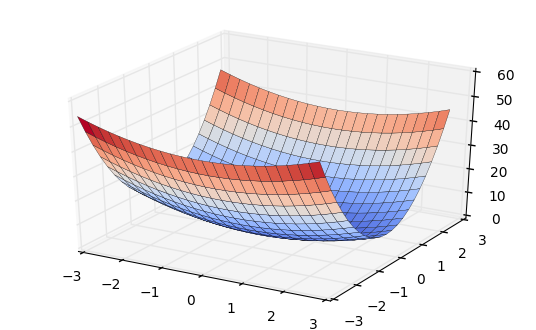

In [11]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X ** 2 + 5 * Y ** 2
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, \
                       cmap=cm.coolwarm, linewidth=0.2, antialiased=True)

plt.show()

На графике видно, что минимум действительно есть. Попробуем теперь найти его методом градиентного спуска. Сначала опишем класс квадратичных функций от двух переменных. Задаваться они будут парой коэффициентов при одночленах $x^2, y^2$ соответственно. Нам хватит двух функций внутри класса - рассчета значения и градиента в точке.

In [12]:
class TwoVarQuadricFunction(object):
    def __init__(self, coefs):
        self.coefs = coefs
    
    def Value(self, x, y):
        return x ** 2 * self.coefs[0] + y ** 2 * self.coefs[1]
    
    def Gradient(self, x, y):
        derivative_x = 2 * self.coefs[0] * x
        derivative_y = 2 * self.coefs[1] * y
        return derivative_x, derivative_y

Теперь напишем сам алгоритм градиентного спуска. Сначала наугад выбираем точку. Фиксируем малое положительное число $\varepsilon$. Далее выполняем по циклу следующее. Считаем градиент в текущей точке $x^k, y^k$, немного двигаем точку в направлении, противоположном градиенту: $x^{k+1}, y^{k+1} = x^k, y^k - \alpha \nabla f(x^k, y^k)$. При этом на каждой итерации добавляем в список текущее значение точки, чтобы можно было посмотреть траекторию алгоритма. Останавливаемся, когда изменение значения функции при шаге мало, точнее, когда его модуль меньше $\varepsilon$.

In [13]:
def GradientDescent(function, x_0, y_0, iterations=-1, alpha=0.1, epsilon=1E-5):
    x, y = x_0, y_0
    in_minimum = False
    x_row = [x]
    y_row = [y]
    while not in_minimum and iterations != 0:
        der_x, der_y = function.Gradient(x, y)
        first_value = function.Value(x, y)
        x -= alpha * der_x
        y -= alpha * der_y
        x_row.append(x)
        y_row.append(y)
        if abs(first_value - function.Value(x, y)) < epsilon:
            in_minimum = True
        if iterations > 0:
            iterations -= 1
    return x_row, y_row

В качестве вспомогательной функции (она нам еще не раз пригодится) будем использовать функцию генерации точки из заданного квадрата $[-r, r] \times [-r, r]$.

In [14]:
def RandomPoint(random_area):
    return list(np.random.uniform(0, random_area, 2))

Создадим функцию, передав ей коэффициенты нашей функции. Запустим на ней алгоритм градиентного спуска с параметром $\alpha = 0.01$ и с параметром $\alpha = 0.1$, получив при этом две последовательности точек из алгоритма - траектории движения. Напечатаем последние точки (т.е. те, которые предположительно являются минимумами функции).

In [15]:
some_function = TwoVarQuadricFunction([1, 5])
x, y = RandomPoint(10)
x_row_long, y_row_long = GradientDescent(some_function, x, y, alpha=0.01)
x_row, y_row = GradientDescent(some_function, x, y, alpha=0.1)
print(x_row_long[-1], y_row_long[-1])
print(x_row[-1], y_row[-1])

0.0155325489086 5.28011262021e-13
0.00414011604291 0.0


Видно, что алгоритм правильно нашел минимум - данные точки очень мало отличаются от настоящего минимума. Посмотрим теперь на двумерный график, изобразив на нем линии уровня и точки, в которые заходил алгоритм в ходе работы для обоих случаев.

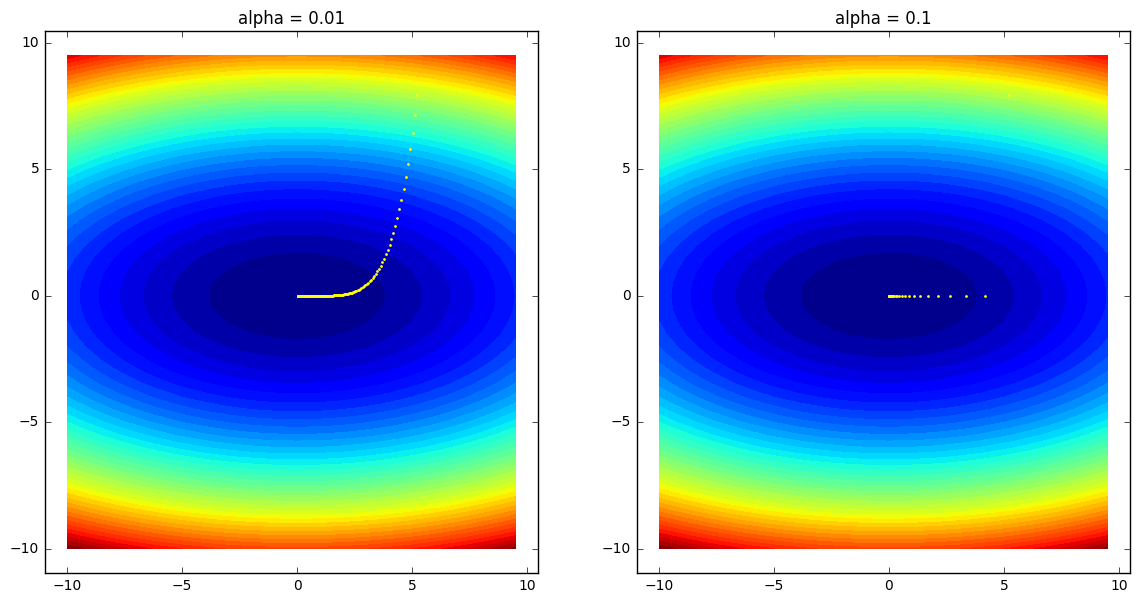

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

X = np.arange(-10, 10, 0.5)
Y = np.arange(-10, 10, 0.5)
X, Y = np.meshgrid(X, Y)
Z = some_function.Value(X, Y)
CS = ax1.contourf(X, Y, Z, 40)
CS = ax2.contourf(X, Y, Z, 40)
ax1.scatter(x_row_long, y_row_long, s=1, color='yellow')
ax2.scatter(x_row, y_row, s=1, color='yellow')
ax1.set_title('alpha = 0.01')
ax2.set_title('alpha = 0.1')
plt.show()

Можно заметить, что каждый раз точка сдвигается в направлении, перпендикулярном линии уровня, проходящей через эту точку. При этом последовательность точек довольно быстро сходится к минимуму при $\alpha = 0.1$ и несколько медленнее при $\alpha = 0.01$. Однако можно отметить, что во втором случае шаг меньше, поэтому вероятность проскочить минимум также меньше. Этот параметр можно определять, анализируя работу алгоритма и изображая ее на графиках. При этом $\alpha$ не должен быть большим, т.к. в этом случае и шаг градиентного спуска будет слишком большим и значения функции будут возрастать.

# Функция Розенброка

Теперь рассмотрим функцию Розенброка: $$f(x, y) = (1-x)^2 + 100(y-x^2)^2.$$ Сразу посчитаем ее частные производные: $$f'_x = 400x(x^2 - y) + 2(x-1), \quad f'_y = 200(y-x^2).$$ Очевидно, что функция неотрицательна. При этом в точке $(1,1)$ ее значение равно нулю. Значит, эта точка является глобальным минимумом. Также ясно, что других глобальных минимумов у этой функции нет. Создадим объект - нашу функцию.

In [17]:
class RosenbrockFunction(object):
    def __init__(self):
        pass
    
    def Value(self, x, y):
        return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
    
    def Gradient(self, x, y):
        der_x, der_y = 400 * x * (x ** 2 - y) + 2 * (x - 1), 200 * (y - x ** 2)
        norm = np.sqrt(der_x ** 2 + der_y ** 2)
        return der_x / norm, der_y / norm

Посмотрим на графике, как она выглядит в окрестновти точки $(0,0)$.

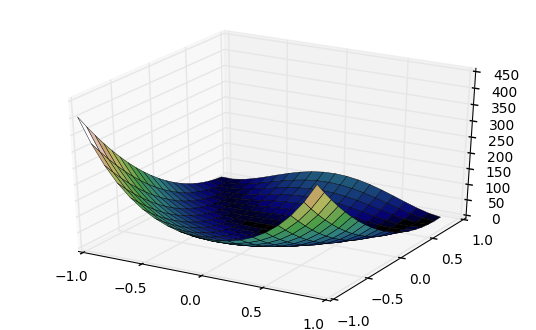

In [18]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
X = np.arange(-1, 1, 0.1)
Y = np.arange(-1, 1, 0.1)
R = RosenbrockFunction()
X, Y = np.meshgrid(X, Y)
Z = R.Value(X, Y)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, \
                       cmap=cm.gist_earth, linewidth=0.3, antialiased=True)

plt.show()

Как из формулы, которая задает функцию, так и и из графика видно, что если $y$ почти равен $x^2$, наша функция ведет себя почти как $(1-x)^2$. При этом из анализа производных и опять же из графика ясно, что при фиксированном значении одной из переменных, функция очень быстро возрастает по второй переменной. Поэтому при использовании метода градиентного спуска точки сначала будут стремиться к параболе $y = x^2$, подходя к ней в перпендикулярном направлении, а после будут сдвигаться по параболе в точку $(1,1)$. Однако возникнут проблемы:
1. Надо брать очень малое значение $\varepsilon$, т.к. функция при движении по параболе убывает медленно, а остановиться нужно только в точке $(1,1)$. Как следствие, шаг также должен быть маленьким.
2. Производные при движении по параболе очень малы. Вкупе с малой длиной шага скорость сходимости будет очень низкая.

Данные проблемы можно решить, изменив шаг градиентного спуска. Наша проблема заключается в том, что мы слишком медленно движемся по ровной линии. Но при движении по ровной линии мы можем прибавлять к текущему шагу предыдущие шаги, двигаясь быстрее - подобные методы разберем позднее.

In [19]:
rosenbrock = RosenbrockFunction()
x, y = RandomPoint(2)
x_row, y_row = GradientDescent(rosenbrock, x, y, alpha=1E-4, epsilon=1E-10)
print(x_row[-1], y_row[-1])
print(len(x_row))

0.999537219384 0.999184746515
12472


Мы видим, что алгоритм нашел минимум, однако, что касается скорости, он работает довольно долго. Посмотрим на траекторию алгоритма.

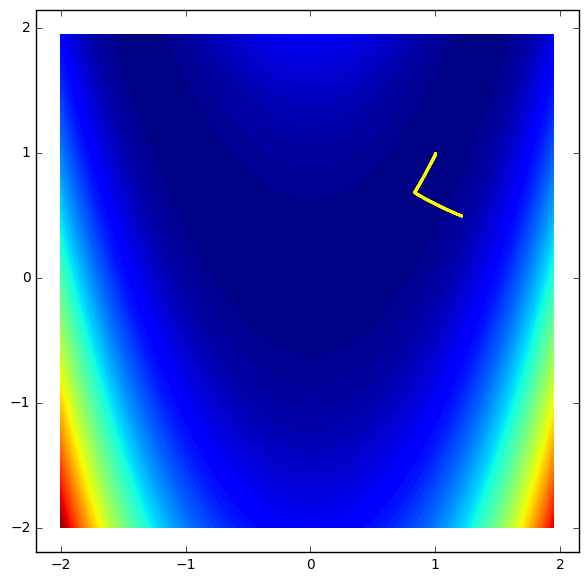

In [20]:
fig, ax = plt.subplots(1, figsize=(7,7))

X = np.arange(-2, 2, 0.05)
Y = np.arange(-2, 2, 0.05)
X, Y = np.meshgrid(X, Y)
R = RosenbrockFunction()
Z = R.Value(X, Y)

CS = ax.contourf(X, Y, Z, 100)
ax.scatter(x_row, y_row, s=0.05, color='yellow')
plt.show()

# Классификация точек методом градиентного спуска

Попробуем сравнить два линейных классификатора, запустив их на облаках точек двух цветов. Для начала зададим квадратичную функцию потерь задачи регрессии.

In [21]:
class MSERegression(object):
    def Value(self, X, Y, coefs):
        return np.linalg.norm(np.dot(X, coefs) - Y)

    def Gradient(self, X, Y, coefs):
        S = np.dot(X, coefs) - Y
        gradient = np.dot(X.T, 2 * S)
        return gradient

Теперь реализуем сам классификатор.

In [22]:
class GradientClassifier(LinearClassifier):
    def fit(self, X, Y, function, alpha=1E-3, epsilon=1E-7):
        dim = X.shape[0]
        X = np.hstack([X, np.ones((dim, 1))])
        in_minimum = False
        while not in_minimum:
            first_loss = function.Value(X, Y, self.coefs)
            gradient = function.Gradient(X, Y, self.coefs)
            
            self.coefs = self.coefs - alpha * gradient
            if abs(function.Value(X, Y, self.coefs) - first_loss) < epsilon:
                in_minimum = True

Создадим снова обучающую выборку.

In [23]:
points_number = 500
blue = GeneratePointCloud((0, 0), points_number)
red = GeneratePointCloud((2.5, 2.5), points_number)

X_train = np.vstack([blue, red])
Y_train = np.vstack([np.ones((points_number, 1)), -np.ones((points_number, 1))])

Обучим на ней новый классификатор.

In [24]:
MSE = MSERegression()
clf = GradientClassifier(2, 'random')
clf.fit(X_train, Y_train, MSE, alpha=1E-4, epsilon=1E-2)
w_1, w_2 = clf.get_coefs()
w_0 = clf.get_intersect()

Построим на графике множества точек и разделяющую прямую.

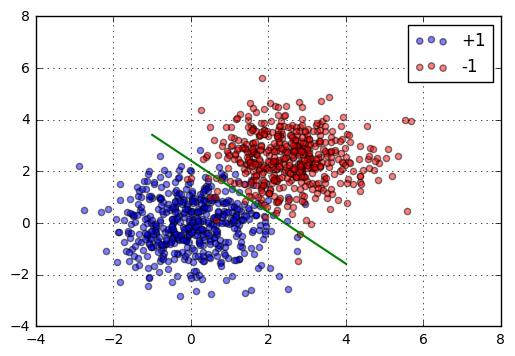

In [25]:
fig, ax = plt.subplots()

plt.scatter(blue[:, 0], blue[:, 1], c='blue', alpha=0.5, label='+1')
plt.scatter(red[:, 0], red[:, 1], c='red', alpha=0.5, label='-1')
plt.plot([-1,4], [line(-1), line(4)], c='green', lw=1.5)

leg = plt.legend()
ax.grid(True)
plt.show()

Посмотрим на результат, получаемый аналитическим решением и результат, получаемый методом градиентного спуска. Для оценки качества будем использовать простую метрику - долю верных ответов.

In [26]:
clf = GradientClassifier(2, 'random')
clf.fit(X_train, Y_train, MSE, alpha=1E-4, epsilon=1E-2)
Y_pred = clf.predict(X_train)
gradient_accuracy = metrics.accuracy_score(Y_train, Y_pred)

clf = AnalyticalClassifier(2, 'random')
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_train)
analytical_accuracy = metrics.accuracy_score(Y_train, Y_pred)

print(gradient_accuracy, analytical_accuracy)

0.973 0.97


Мы видим, что у обоих классификаторов результат получился примерно одинаковый (в данной метрике), причем довольно высокий. Однако одна из проблем градиентного спуска - его возможно долгое время работы. Одна из модификаций, решающих эту проблему - метод наискорейшего спуска. Попробуем добавить это улучшение в наш алгоритм. Заметим, что $\alpha$ теперь необходимо брать так, чтобы величина $$\sum\limits_{x, y}Q(xw^k + b^k - y)^2$$ была минимальной. Мы знаем, как в нашем случае выглядит функция $Q$, поэтому сразу можем предложить оптимальное значение $\alpha$ - вершину параболы: $$\alpha = \frac{\sum\limits_{x, y}(xw + b - y)(x \nabla Q)}{\sum\limits_{x, y}(x \nabla Q)^2}.$$

In [27]:
class GradientClassifier(LinearClassifier):
    def fit(self, X, Y, function, alpha=1E-3, epsilon=1E-7, info=False):
        is_fast = False
        if alpha == -1:
            is_fast = True
        dim = X.shape[0]
        X = np.hstack([X, np.ones((dim, 1))])
        in_minimum = False
        
        Q_row = []
        
        while not in_minimum:
            first_loss = function.Value(X, Y, self.coefs)
            gradient = function.Gradient(X, Y, self.coefs)
            if info:
                Q_row.append(first_loss)
            
            if is_fast:
                D = np.dot(X, gradient)
                alpha = np.sum((np.dot(X, self.coefs) - Y) * D)
                alpha /= np.sum(D ** 2)

            self.coefs = self.coefs - alpha * gradient
            if abs(function.Value(X, Y, self.coefs) - first_loss) < epsilon:
                in_minimum = True
        if info:
            return np.array(Q_row)

Для использования метода скорейшего градиентного спуска необходимо задать параметр $\alpha$ равным $-1$. Мы также добавили возможность отслеживать траекторию сходимости алгоритма. Теперь сравним скорости сходимости обычного градиентного спуска и метода наискорейшего спуска в данной задаче.

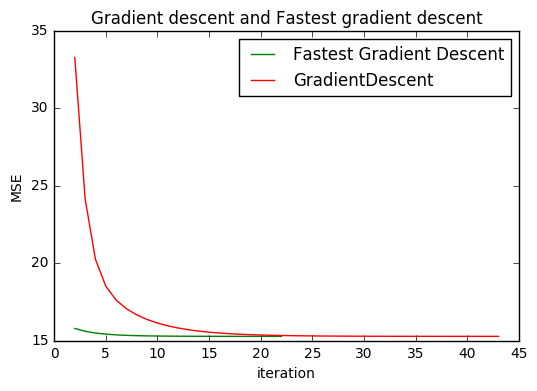

In [28]:
clf = GradientClassifier(2, 'random')
Q_fast = clf.fit(X_train, Y_train, MSE, alpha=-1, epsilon=1E-4, info=True)

clf = GradientClassifier(2, 'random')
Q_slow = clf.fit(X_train, Y_train, MSE, alpha=1E-4, epsilon=1E-4, info=True)

plt.plot(range(len(Q_fast))[2:], Q_fast[2:], c='green', label='Fastest Gradient Descent')
plt.plot(range(len(Q_slow))[2:], Q_slow[2:], c='red', label='GradientDescent')
plt.title('Gradient descent and Fastest gradient descent')
plt.xlabel('iteration')
plt.ylabel('MSE')

plt.legend()
plt.show()

Т.к. значения функции потерь в первой точке обычно большие, мы будем смотреть на значения, начиная с третьей итерации. На графике видно, что алгоритм наискорейшего спуска в данной задаче значительно быстрее сходится к минимуму, чем обычный алгоритм градиентного спуска. Тем не менее, и в этом случае у градиентного спуска есть недостатки. Один из них - если какой-то признак в обучающей выборке встречается редко (т.е. соотетствующая ему координата разреженна), то частная производная $Q$ по соответствующему весу всегда будет маленькой, поэтому по этой координате градиент будет сходиться довольно медленно.

# Стохастический градиентный спуск и MNIST

Иногда объем данных бывает слишком большой, поэтому делать градиентный спуск на все выборке не представляется возможным. Другой пример - когда данные подаются в виде потока, а хранить их в памяти также невозможно. Эта проблема может быть решена с помощью стохастического градиентного спуска. Но для начала определимся с данными. Будем использовать датасет $MNIST$ для распознавания цифр. Но, поскольку мы изучаем задачу бинарной классификации, ограничимся распознаванием цифр $0$ и $1$. Для этого в обучающую выборку запишем только строки, соответствующие $0$ и $1$. Их будет порядка $8$ тысяч. Признаки - это цвет пикселя для каждого пикселя на изображении. Каждый объект выборки имеет размер $28 \times 28$, поэтому признаков будет $785$ (мы всегда будем добавлять к выборке столбец из $1$, отвечающий за свободный член линейной функции). Не забудем присвоить цифрам метки классов - $+1$ для $1$ и $-1$ для $0$.

In [29]:
import pandas as pd

data = pd.read_csv('train.csv', sep=',')
data01 = data[data['label'] < 2].values

data_division = 0.7

X_train = data01[: round(data01.shape[0] * data_division), 1 :]
Y_train = data01[: round(data01.shape[0] * data_division), 0 : 1] * 2 - 1

X_test = data01[round(data01.shape[0] * data_division) :, 1 :]
Y_test = data01[round(data01.shape[0] * data_division) :, 0 : 1] * 2 - 1

Для начала научимся вычислять значение и градиент логистической функции потерь в задаче регрессии. Мы уже знаем, что $$Q = \frac{1}{l}\sum\limits_{x, y \in X^l} \ln{(1 + e^{-y(wx + b)})}.$$ Осталось найти градиент этой функции: $$\frac{dQ}{dw_i} = \sum\limits_{x, y \in X^l} -y x_i \frac{e^{-y(wx+b)}}{1 + e^{-y(wx+b)}}.$$

In [30]:
class LogisticRegression(object):
    def Value(self, X, Y, coefs):
        S = -(np.dot(X, coefs)) * Y
        loss = np.mean(np.log(1 + np.e ** S))
        return loss

    def Gradient(self, X, Y, coefs):
        S = -(np.dot(X, coefs)) * Y
        S = -Y * (np.e ** S / (1 + np.e ** S))
        gradient = np.dot(X.T, S) / X.shape[0]
        return gradient

Теперь реализуем непосредственно $SGD$. Функция $step$ остается без изменений (та же функция $fit$, но без лишних для стохастического градиентного спуска параметров) - она отвечает обычной регрессии с произвольной функцией эмпирического риска. Добавим функцию $fit$. Она принимает обучающую выборку, количество итераций и размер батча. Далее происходит следующее: обучающая выборка последовательно делится на блоки фиксированного размера (батчи), после чего для каждого батча по очереди выполняется одна итерация обычного градиентного спуска. Так алгоритм проходит по всей выборке заданное число раз.

In [31]:
class SGD(LinearClassifier):
    def step(self, function, X, Y, alpha=1E-3, info=False):
        dim = X.shape[0]
        X = np.hstack([X, np.ones((dim, 1))])
        n = X.shape[1]
        
        loss = function.Value(X, Y, self.coefs)
        gradient = function.Gradient(X, Y, self.coefs)
                 
        self.coefs = self.coefs - alpha * gradient
        
        if info:
            return loss
        
    def fit(self, function, X, Y, iteration=1, batch=10, alpha=1E-5, info=False):
        Q = []
        while iteration > 0:
            for i in range(0, X.shape[0] // batch):
                loss = self.step(function, X[batch * i : batch * (i + 1), :], Y[batch * i : batch * (i + 1), :],\
                                alpha=alpha, info=True)
                if info:
                    Q.append(loss)
            iteration -= 1
        return Q
            
    def predict(self, X):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        Y_pred = np.dot(X, self.coefs)
        Y_pred = 1 / (1 + np.e ** (-Y_pred))
        return (Y_pred > 0.5) * 2 - 1

Функция $predict$ по заданной выборке возвращает предсказанные значения цифр ($0$ или $1$) так: мы знаем, что минимизация логистической функции потерь имеет вероятностный смысл. Это в точности максимизация правдоподобия при $$P(y = 1 \ | \ x) = \frac{1}{1+e^{-(wx+b)}}.$$ Поэтому для определения цифры мы посчитаем эту вероятность и вернем $1$, если она больше $0.5$ и $0$ в противном случае. Теперь непосредственно обучим наш классификатор и посмотрим на результат (долю верных ответов на отложенной тестовой выборке).

In [32]:
sgd = SGD(X_train.shape[1], 'zeros')
logreg = LogisticRegression()
sgd.fit(logreg, X_train, Y_train, iteration=10, batch=100, alpha=1E-5, info=True)
Y_pred = sgd.predict(X_test)
print(metrics.accuracy_score(Y_test, Y_pred))

0.999243856333


Получаем довольно большую точность. Но интересно посмотреть, как зависит точность и скорость сходимости от размера батча. Для этого запустим алгоритм при значениях размера батча $1, 10, 50, 100$ и посмотрим на график зависимости функции потерь для рассматриваемого батча от итерации (здесь итерация - шаг градиентного спуска).

In [33]:
sgd = SGD(X_train.shape[1], 'zeros')
Q_1 = sgd.fit(logreg, X_train, Y_train, iteration=10, batch=1, alpha=1E-5, info=True)

sgd = SGD(X_train.shape[1], 'zeros')
Q_10 = sgd.fit(logreg, X_train, Y_train, iteration=10, batch=10, alpha=1E-5, info=True)

sgd = SGD(X_train.shape[1], 'zeros')
Q_50 = sgd.fit(logreg, X_train, Y_train, iteration=10, batch=50, alpha=1E-5, info=True)

sgd = SGD(X_train.shape[1], 'zeros')
Q_100 = sgd.fit(logreg, X_train, Y_train, iteration=10, batch=100, alpha=1E-5, info=True)

Получили значения функции потерь. Перенесем их на графики.

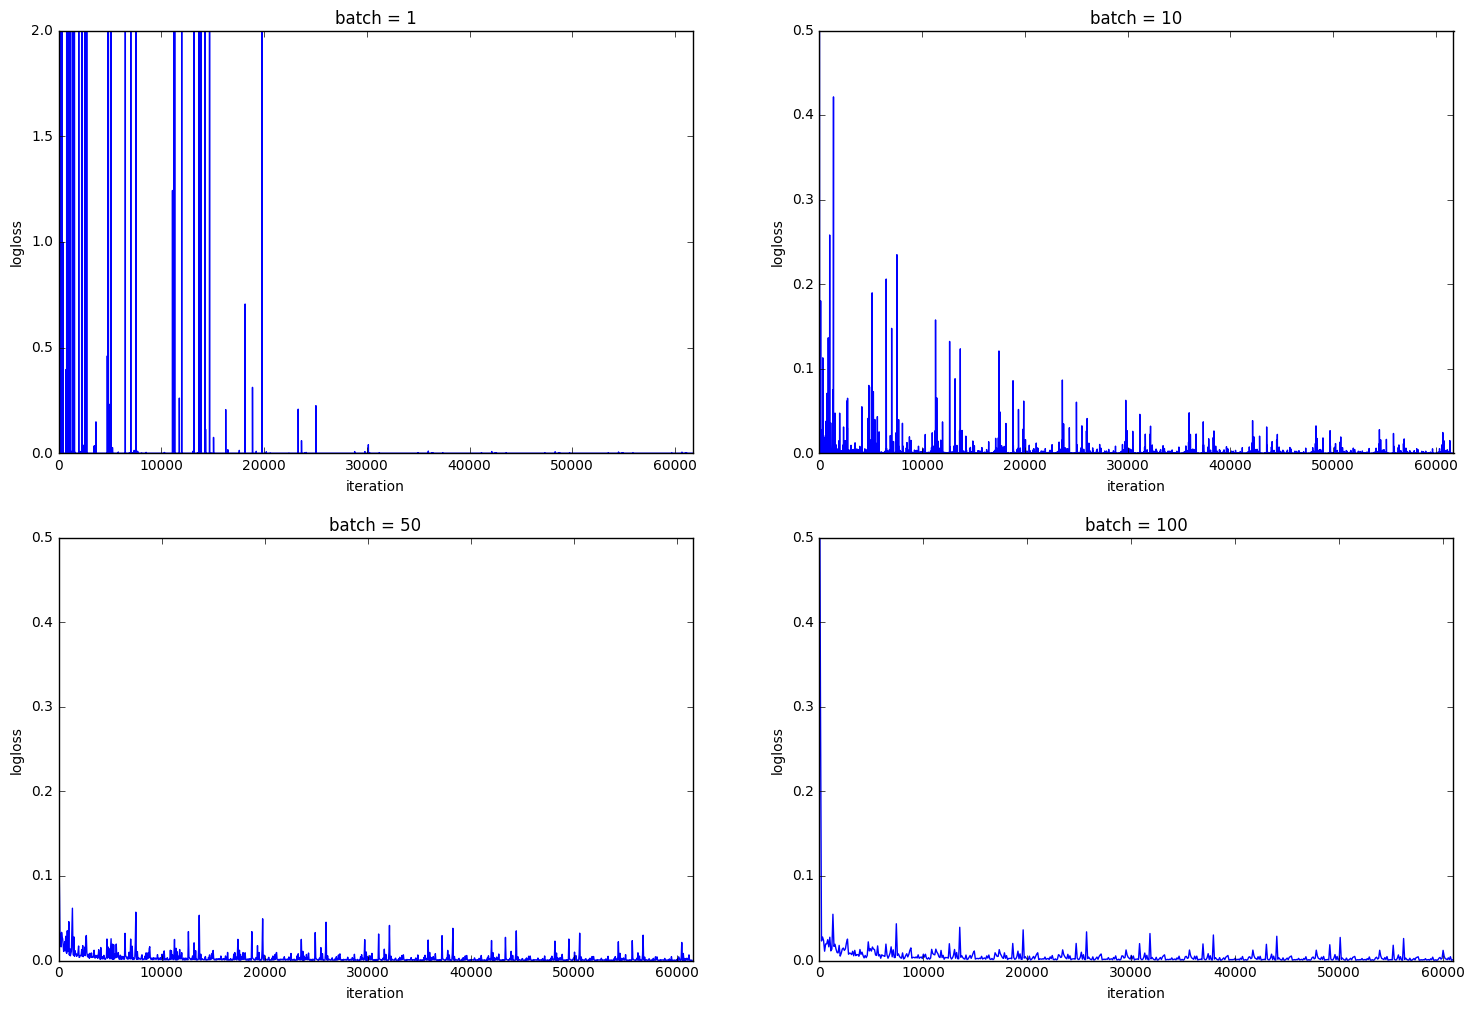

In [34]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
ax1.axis([0, len(Q_1), 0, 2])
ax2.axis([0, 10 * len(Q_10), 0, 0.5])
ax3.axis([0, 50 * len(Q_50), 0, 0.5])
ax4.axis([0, 100 * len(Q_100), 0, 0.5])
ax1.set_title('batch = 1')
ax2.set_title('batch = 10')
ax3.set_title('batch = 50')
ax4.set_title('batch = 100')

ax1.set_xlabel('iteration')
ax1.set_ylabel('logloss')
ax1.plot(range(len(Q_1)), Q_1)

ax2.set_xlabel('iteration')
ax2.set_ylabel('logloss')
ax2.plot([10 * i for i in range(len(Q_10))], Q_10)

ax3.set_xlabel('iteration')
ax3.set_ylabel('logloss')
ax3.plot([50 * i for i in range(len(Q_50))], Q_50)

ax4.set_xlabel('iteration')
ax4.set_ylabel('logloss')
ax4.plot([100 * i for i in range(len(Q_100))], Q_100)

plt.show()

Таким образом, мы видим, что при различных значениях батча градиент сходится довольно хорошо. При батче размера 1 (т.е. выборе элементов по очереди) сходимость хорошая, но медленная, а при больших значениях сходимость тем быстрее, чем больше батч. За итерацию на графике принимается размер батча. При этом необходимое количество проходов по данным до хорошей сходимости может варьироваться. Можно смотреть на результат при различном числе проходов, а можно сделать условие остановки - например, если среднее значение функции ошибки за последние $k$ итераций меньше $\varepsilon$.

# Экспоненциальное сглаживание

Для выравнивания последовательности $Q_1, Q_2, \ldots, Q_n$, где $n$ - это номер итерации алгоритма можно воспользоваться экспоненциальным сглаживанием: Построить новую последовательность $Q^*_i$, где $Q^*_1 = Q_1$, а $Q^*_i = \gamma Q^*_{i-1} + (1-\gamma) Q_i$. Таким образом мы "смягчаяем" скачки функции потерь для каждого батча, т.к. берем не само значение функции потерь, а число между предыдущим полученным значением и данным. Для начала напишем функцию, осуществляющую экспоненчиальное сглаживание и возьмем последовательность значений функции потерь для предыдущей задачи.

In [35]:
def ExpSmooth(Q, gamma):
    Q_2 = [Q[0]]
    for i in range(1, len(Q)):
        Q_2.append(Q_2[i - 1] * gamma + Q[i] * (1 - gamma))
    return Q_2

sgd = SGD(X_train.shape[1], 'zeros')
Q_1 = sgd.fit(logreg, X_train, Y_train, iteration=10, batch=10, alpha=1E-5, info=True)

Посмотрим, как при различных значениях параметра $\gamma$ выглядит график ошибки от итерации.

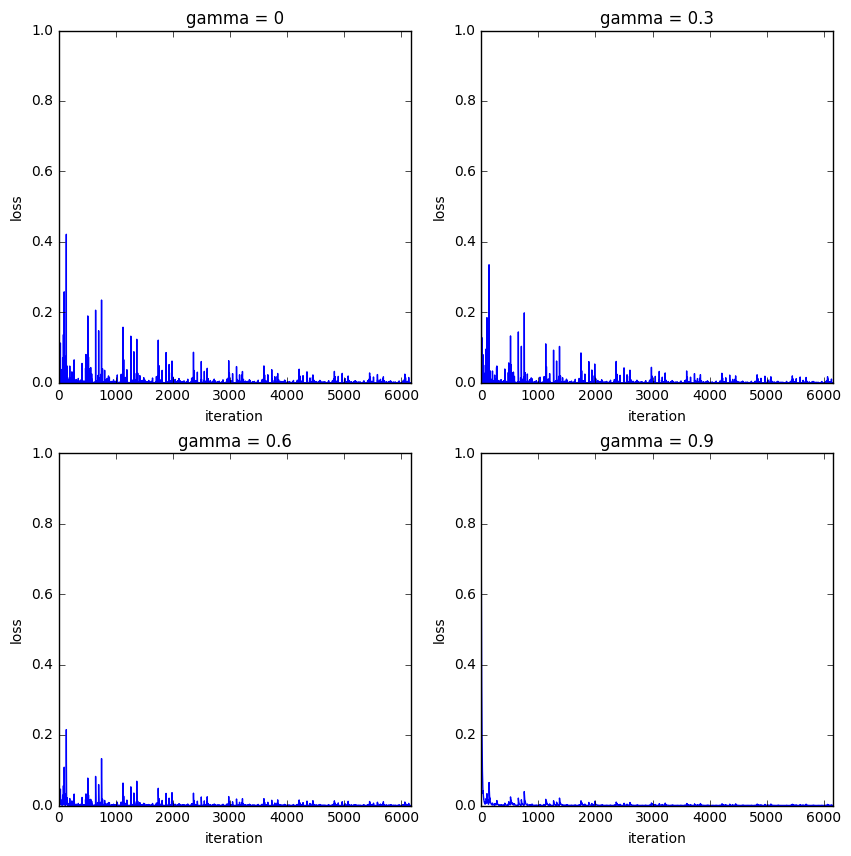

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
ax1.axis([0, len(Q_1), 0, 1])
ax2.axis([0, len(Q_1), 0, 1])
ax3.axis([0, len(Q_1), 0, 1])
ax4.axis([0, len(Q_1), 0, 1])
ax1.set_title('gamma = 0')
ax2.set_title('gamma = 0.3')
ax3.set_title('gamma = 0.6')
ax4.set_title('gamma = 0.9')
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss')
ax2.set_xlabel('iteration')
ax2.set_ylabel('loss')
ax3.set_xlabel('iteration')
ax3.set_ylabel('loss')
ax4.set_xlabel('iteration')
ax4.set_ylabel('loss')

ax1.plot(range(len(Q_1)), Q_1)

gamma = 0.3
Q_2 = ExpSmooth(Q_1, gamma)
ax2.plot(range(len(Q_2)), Q_2)

gamma = 0.6
Q_2 = ExpSmooth(Q_1, gamma)
ax3.plot(range(len(Q_2)), Q_2)

gamma = 0.9
Q_2 = ExpSmooth(Q_1, gamma)
ax4.plot(range(len(Q_2)), Q_2)

plt.show()

Ясно, что при $\gamma = 0$ мы получаем в точности исходную последовательность. При $\gamma = 1$ имеем прямую $Q = Q_1$. На промежуточных значениях график сглаживается при $\gamma$ от 0 до 1 (чем больше значение параметра, тем более гладкий график). Этот метод может быть полезен для анализа скорости сходимости и общей траектории изменения значения.

# Сохранение импульса

Допустим, мы захотим минимизировать функцию $10x^2 + y^2$. Ясно, что минимум достигается только в точке $(0, 0)$. Но если мы воспользуемся алгоритмом градиентного спуска, то столкнемся с проблемой. Сначала точка будет двигаться в сторону минимума, приближаясь к прямой $x = 0$, после чего будет двигаться очень медленно вдоль этой прямой (позже проиллюстрируем это на графиках). Здесь может помочь метод сохранения импулься. Каждый раз будем уменьшать вектор коэффициентов не на $\alpha \nabla Q$, а на $s_k = \gamma s_{k-1 } + \alpha \nabla Q$. Т.е. мы будем учитывать предыдущие значения градиента так, что чем дальше мы ушли от какой-то итерации, тем меньше мы учитываем значение градиента на этой итерации (это значение стремится к $0$).

In [37]:
def Momentum(function, x_0, y_0, iterations=-1, alpha=0.1, epsilon=1E-5, gamma=0.7):
    x, y = x_0, y_0
    in_minimum = False
    x_row = [x]
    y_row = [y]
    sx_prev, sy_prev = 0, 0
    while not in_minimum and iterations != 0:
        der_x, der_y = function.Gradient(x, y)
        first_value = function.Value(x, y)
        sx = gamma * sx_prev + alpha * der_x
        sy = gamma * sy_prev + alpha * der_y
        x -= sx
        y -= sy
        x_row.append(x)
        y_row.append(y)
        if abs(first_value - function.Value(x, y)) < epsilon:
            in_minimum = True
        if iterations > 0:
            iterations -= 1
        sx_prev, sy_prev = sx, sy
    return x_row, y_row

Теперь сравним обычный метод градиентного спуска и метод сохранения импульса на вышеупомянутой функции (с одинаковыми значениями параметров).

In [38]:
some_function = TwoVarQuadricFunction([10, 1])
x, y, = -10, -10
x_row, y_row = GradientDescent(some_function, x, y, alpha=1E-2, epsilon=1E-8)
x_row_momentum, y_row_momentum = Momentum(some_function, x, y, alpha=1E-2, epsilon=1E-8, gamma=0.8)

Параметр $\gamma$ можно выбирать стандартно: запустить алгоритм несколько раз с различными значениями параметра и взять оптимальный. Стоит отметить, что $\gamma$ не должна быть слишком большой, т.к. в этом случае алгоритм рискует разойтись за счет слишком большой инерции. Итак, посмотрим сначала на минимумы, которые нашли два алгоритма.

In [39]:
print(x_row[-1], y_row[-1])
print(x_row_momentum[-1], y_row_momentum[-1])

-2.6132659696365936e-47 -0.0004920431215390621
-8.420723897767867e-05 0.0002428625031246255


Мы видим, что обычный градиентный спуск нашел минимум с крайне маленьким значением $x$. Это подтверждает то, что траектория шла вдоль прямой $x = 0$, все время приближаясь к ней. Но при этом оба алгоритма нашли достаточно точные значения минимума. Гораздо интереснее - как быстро они их нашли. Посмотрим на количество итераций, которое сделал каждый алгоритм.

In [40]:
print(len(x_row), len(x_row_momentum))

492 93


Метод сохранения импульса работает ощутимо быстрее обычного градиентного спуска. Посмотрим на то, какую траекторию он проходит, на графике.

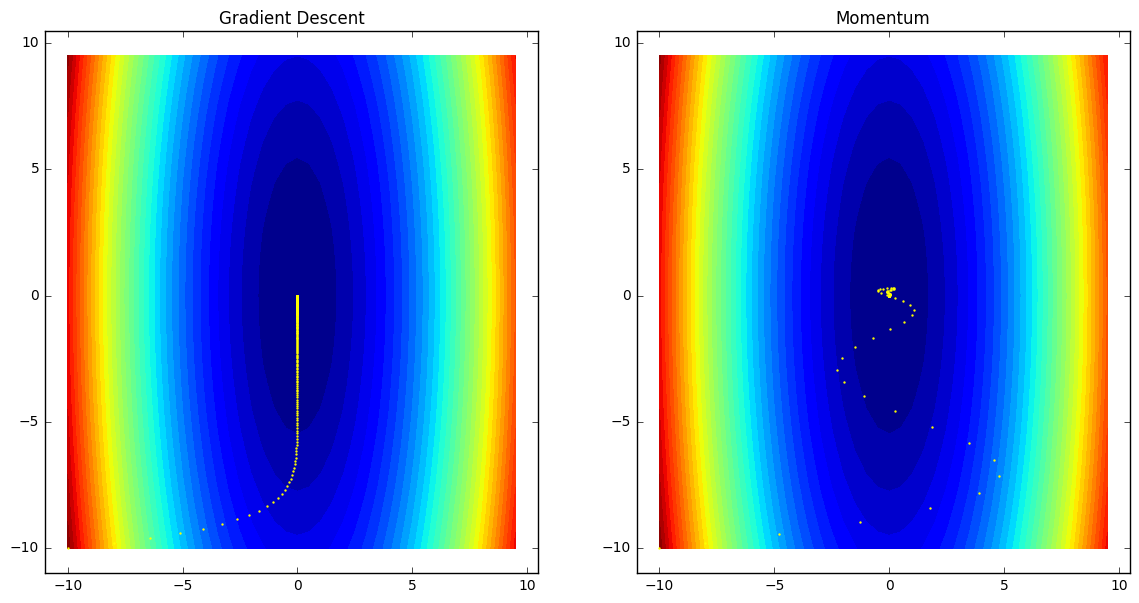

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

X = np.arange(-10, 10, 0.5)
Y = np.arange(-10, 10, 0.5)
X, Y = np.meshgrid(X, Y)
Z = some_function.Value(X, Y)
CS = ax1.contourf(X, Y, Z, 40)
CS = ax2.contourf(X, Y, Z, 40)
ax1.scatter(x_row, y_row, s=0.5, color='yellow')
ax2.scatter(x_row_momentum, y_row_momentum, s=0.5, color='yellow')
ax1.set_title('Gradient Descent')
ax2.set_title('Momentum')
plt.show()

В отличие от обычного градиентного спуска, метод сохранения импульса движется не по ровной линии, а по извилистой. При этом его шаги больше по длине. Это можно сравнить с движением точки по гладкой чаше: она движется не по направлению самого крутого наклона в каждой точке, а по направлению, задаваемому как наклоном, так и инерцией.

# Ускоренный градиент Нестерова

Идейное продолжение предыдущего метода - ускоренный градиент Нестерова. Смысл очень похож на метод сохранения импульса, однако есть важное различие. При сохранении импульса мы двигались только по направлению градиента, учитывая градиент в данной точке и предыдущие значения градиента. Однако в таком случае мы могли сильно перескочить меньшее значение функции, если направления всех градиентов на последних итерациях почти совпадают (например, для функции Розенброка мы могли перескочить интересующий нас "овраг"). Значит, нельзя брать слишком большое значение $\gamma$. Но тогда мы не максимально используем важное преимущество этого метода - быстрое движение по прямой (за счет прибавления к градиенту добавки, почти совпадающей с ним по направлению). Решение - вычислять градиент не в данной точке, а в той, куда мы сместимся, вычитая только добавку. Т.е. мы движемся по инерции за счет предыдущих значений градиента, но предсказываем, куда надо будет двигаться дальше, и корректируем траекторию.

In [42]:
def NAG(function, x_0, y_0, iterations=-1, alpha=0.1, epsilon=1E-5, gamma=0.7):
    x, y = x_0, y_0
    in_minimum = False
    x_row = [x]
    y_row = [y]
    sx_prev, sy_prev = 0, 0
    while not in_minimum and iterations != 0:
        der_x, der_y = function.Gradient(x, y)
        first_value = function.Value(x, y)
        sx = gamma * sx_prev + alpha * function.Gradient(x - sx_prev, y - sy_prev)[0]
        sy = gamma * sy_prev + alpha * function.Gradient(x - sx_prev, y - sy_prev)[1]
        x -= sx
        y -= sy
        x_row.append(x)
        y_row.append(y)
        if abs(first_value - function.Value(x, y)) < epsilon:
            in_minimum = True
        if iterations > 0:
            iterations -= 1
        sx_prev, sy_prev = sx, sy
    return x_row, y_row

Для сравнения всех трех методов ($GD, Momentum, NAG$) запустим их из одной точки для функции Розенброка с одинаковыми параметрами. Из-за вышеописанной проблемы, значение $\gamma$ для сохранения импульса оставим равным $0.8$ (при больших алгоритм не сойдется), а для градиента Нестерова возьмем большое значение $\gamma = 0.99$.

In [43]:
x, y = RandomPoint(2)

x_row, y_row = GradientDescent(rosenbrock, x, y, alpha=1E-4, epsilon=1E-8)
print(x_row[-1], y_row[-1])
x_row_nesterov, y_row_nesterov = NAG(rosenbrock, x, y, alpha=1E-4, epsilon=1E-8, gamma=0.99)
print(x_row_nesterov[-1], y_row_nesterov[-1])
x_row_momentum, y_row_momentum = Momentum(rosenbrock, x, y, alpha=1E-4, epsilon=1E-8, gamma=0.8)
print(x_row_momentum[-1], y_row_momentum[-1])

0.997444627429 0.994997192028
0.992977603951 0.986053719916
0.999195107179 0.998325465617


Видно, что алгоритмы достаточно хорошо нашли минимум функции. Но посмотрим, за какое число итераций они до него добрались.

In [44]:
print(len(x_row), len(x_row_nesterov), len(x_row_momentum))

14840 1244 2825


Можно отметить полный проигрыш обычного градиентного спуска. Оба улучшения значительно быстрее. Однако, если сравнить их между собой, значительно быстрее окажется, как и ожидалось, градиент Нестерова. Посмотрим на траектории движения точки при работе алгоритмов.

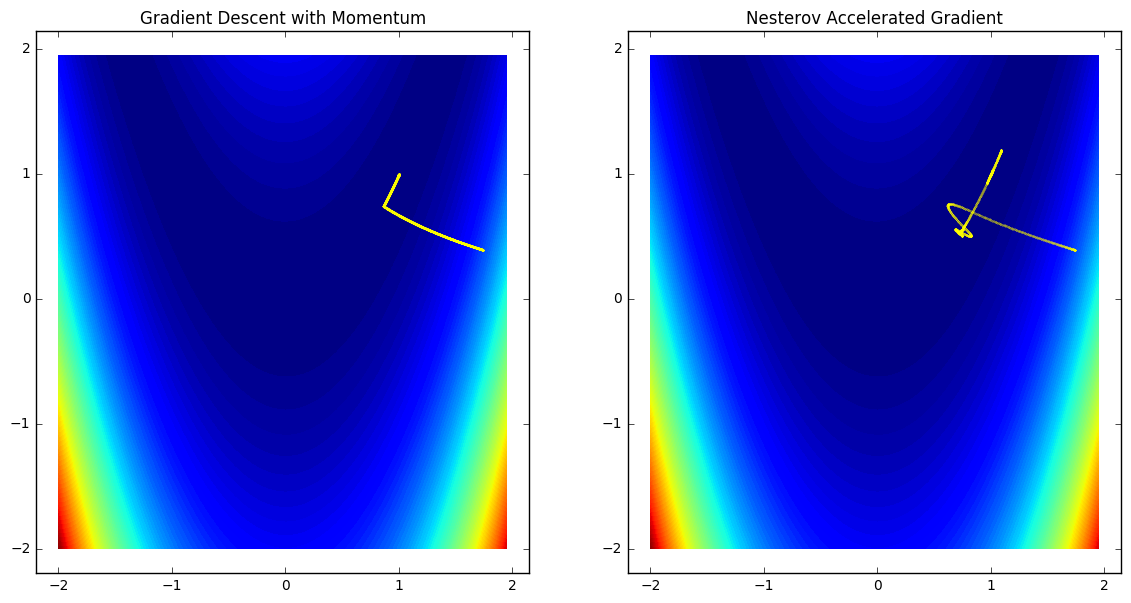

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

X = np.arange(-2, 2, 0.05)
Y = np.arange(-2, 2, 0.05)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock.Value(X, Y)
CS = ax1.contourf(X, Y, Z, 100)
CS = ax2.contourf(X, Y, Z, 100)
ax1.scatter(x_row_momentum, y_row_momentum, s=0.05, color='yellow')
ax2.scatter(x_row_nesterov, y_row_nesterov, s=0.05, color='yellow')
ax1.set_title('Gradient Descent with Momentum')
ax2.set_title('Nesterov Accelerated Gradient')
plt.show()

Видно, что траектория движения градиента Нестерова плавнее. К тому же, вдоль прямой он, как было сказано ранее, движется быстрее. Если бы мы задали большее значение параметра для метода сохранения импульса, его траектория отличалась бы от обычной траектории градиентного спуска, но за счет сильного возрастания функции Розенброка алгоритм бы разошелся.

# Adagrad

Одна из модификаций стохастического градиентного спуска - метод адаптивного градиента. Он заключается в том, что $\alpha$ выбирается для каждого признака индивидуально. А именно - $\alpha_i$ дополнительно делится на корень из суммы всех предыдущих частных производных по $\alpha_i$. Таким образом можно добиться того, чтобы для признаков, встречающихся редко, коэффициент был больше, чем для частых признаков. Это зачастую увеличивает скорость сходимости для разреженных данных. Итак, в данном алгоритме коэффициенты изменяются следующим образом: $$w_{i}^{k + 1} = w_{i}^{k} - \frac{\alpha}{\sqrt{G_{i, i}^k } + \varepsilon} \cdot \frac{dQ}{dx_i},$$ где $$G^k = \sum\limits_{m=1}^{k} \nabla Q_t ^2.$$

In [46]:
class StochasticAdagrad(LinearClassifier):
    def step(self, function, X, Y, G, iteration=0, alpha=1E-3, epsilon=1E-7, info=False, delta=1E-5):
        dim = X.shape[0]
        X = np.hstack([X, np.ones((dim, 1))])
        n = X.shape[1]
        
        loss = function.Value(X, Y, self.coefs)
        gradient = function.Gradient(X, Y, self.coefs)
        G += gradient * gradient
        
        self.coefs = self.coefs - alpha * gradient / (np.sqrt(G + delta))
            
        if info:
            return loss
        
    def fit(self, function, X, Y, iteration=1, batch=10, alpha=1E-5, epsilon=1E-7, info=False):
        Q = []
        G = np.zeros((X.shape[1] + 1, 1))
        while iteration > 0:
            for i in range(0, X.shape[0] // batch):
                loss = self.step(function, X[batch * i : batch * (i + 1), :], Y[batch * i : batch * (i + 1), :],\
                                G, alpha=alpha, info=True)
                if info:
                    Q.append(loss)
            iteration -= 1
        return Q
    
    def predict(self, X):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        Y_pred = np.dot(X, self.coefs)
        Y_pred = np.ones((X.shape[0], 1)) / (np.ones((X.shape[0], 1)) + np.e ** (-Y_pred))
        return (Y_pred > 0.5) * 2 - 1

Попробуем на тех же данных $MNIST$ обучить два классификатора - обычный $SGD$ и $Adagrad$ - с размером батча $10$.

In [47]:
sgd = SGD(X_train.shape[1], 'zeros')
sadagrad = StochasticAdagrad(X_train.shape[1], 'zeros')
logreg = LogisticRegression()
Q_1 = sgd.fit(logreg, X_train, Y_train, iteration=1, batch=10, alpha=1E-4, info=True)
Q_2 = sadagrad.fit(logreg, X_train, Y_train, iteration=1, batch=10, alpha=1E-3, info=True)

Прежде всего посмотрим на качество классификации на отложенной выборке, чтобы убедиться в том, что классификаторы обучились достаточно хорошо.

In [48]:
Y_pred_sadagrad = sadagrad.predict(X_test)
Y_pred_sgd = sgd.predict(X_test)
print(metrics.accuracy_score(Y_test, Y_pred_sgd), metrics.accuracy_score(Y_test, Y_pred_sadagrad))

0.99584120983 0.999243856333


Видим, что оба классификатора обучились достаточно хорошо, но адаптивный градиент чуть лучше. Уже можно сделать предположение о его лучшей сходимости. Посмотрим на графики зависимости ошибки от итерации алгоритма для обоих классификаторов.

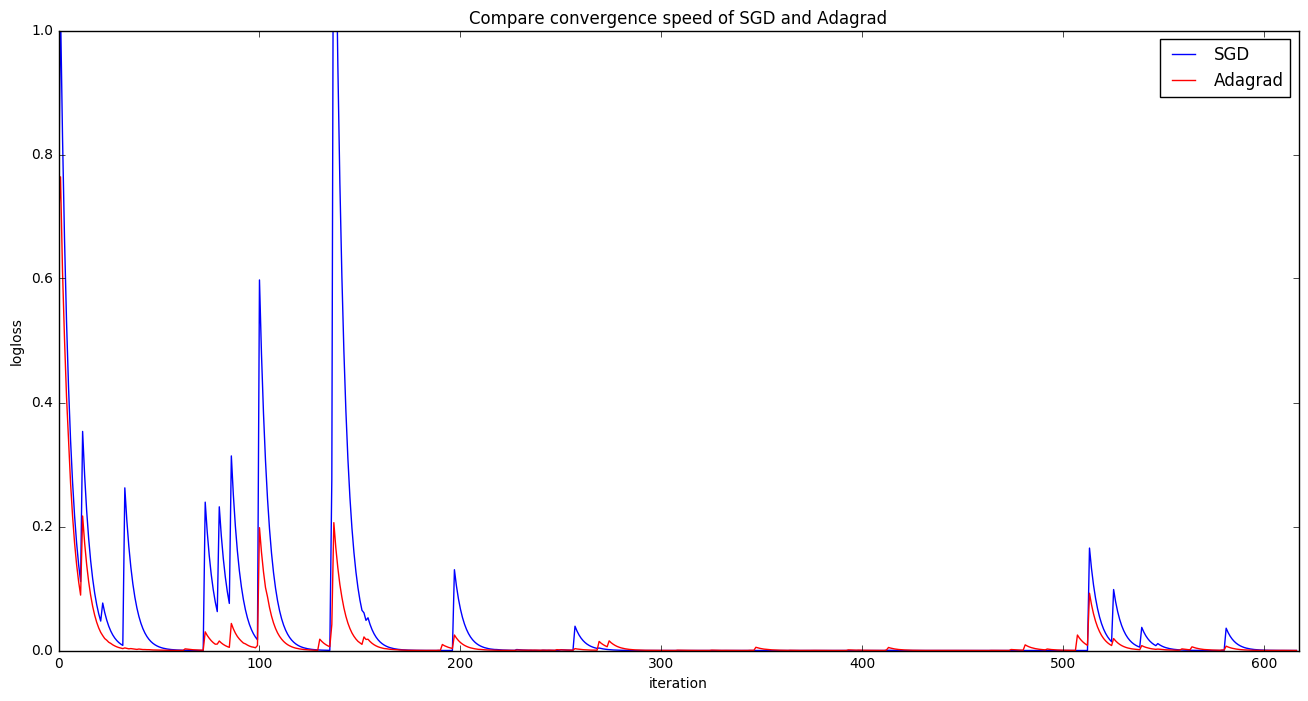

In [49]:
fig, ax = plt.subplots(1, figsize=(16, 8))

ax.set_title('Compare convergence speed of SGD and Adagrad')

Q_1sm = ExpSmooth(Q_1, 0.8)
Q_2sm = ExpSmooth(Q_2, 0.8)
ax.axis([0, len(Q_1sm), 0, 1])

ax.plot(range(len(Q_1sm)), Q_1sm, label='SGD')
ax.plot(range(len(Q_2sm)), Q_2sm, c='red', label='Adagrad')

ax.set_xlabel('iteration')
ax.set_ylabel('logloss')

plt.legend()
plt.show()

Как и ожидалось, классификаторы сходятся примерно с равной скоростью к минимуму, но адаптивный градиент показывает результат немного лучше.

# Adadelta

Заметим, что у $Adagrad$ есть существенный недостаток - слишком быстро растущий знаменатель для некоторых признаков. Эту проблему можно решить следующим образом: вычислять не сумму квадратов градиентов, а среднеквадратичное значение. Причем вычислять, используя экспоненциальное сглаживание. Т.е. $$G^k = E[\nabla Q^2]_k = \gamma E[\nabla Q ^2]_{k-1} + (1-\gamma) \nabla Q_k^2.$$ Тогда знаменатель примет вид $$\sqrt{E[\nabla Q^2]_k + \varepsilon} = RMS(\nabla Q)_k.$$

Однако хотелось бы, чтобы размерность коэффициентов в числителе и знаменателе совпадала. Но размерность в знаменателе равна размерности градиента, которая равна $\frac{1}{\text{размерность $w$}}$ (мы считаем, что значение функции безразмерно). Тогда можно воспользоваться тем, что изменение весов имеет ту же размерность, что и градиент. Тогда можно вычислять среднее значение квадрата изменения веса:
$$E[\Delta w^2]_k = \gamma E[\Delta w^2]_{k-1} + (1-\gamma)\Delta w_k^2.$$
Тогда $$RMS(\Delta w)_k = \sqrt{E[\Delta w^2]_k + \varepsilon}.$$
Но значение $\Delta w_k$ на шаге $k$ нам неизвестно, поэтому данную величину аппроксимируем предыдущим значением, т.е. $RMS(\Delta w)_{k-1}$. Получаем итоговую формулу алгоритма $Adadelta$: $$w_{k+1} = w_k - \frac{RMS(\Delta w)_{k-1}}{RMS(\nabla Q)_k}\nabla Q$$

# Adam

В качестве еще одной модификации рассмотрим алгоритм $Adam$. В нем мы будем делать следующее:
$$m_k = \beta_1 m_{k-1} + (1 - \beta_1) \nabla Q, \\ v_k = \beta_2 v_{k-1} + (1 - \beta_2) \nabla Q, $$ т.е. считать среднее значение градиента и среднее значение квадрата градиента. Далее положим $$m^*_k = \frac{m_k}{1 - \beta_1^k}, \\ v^*_k = \frac{v_k}{1 - \beta_2^k},$$ т.е. при с ростом шагов будем уменьшать обе величины. В итоге уменьшим веса по тому же принципу, что и в $Adadelta$: $$w_{k+1} = w_k - \frac{\alpha}{\sqrt{v^*_k + \varepsilon}}m^*_k.$$

In [50]:
class StochasticAdam(LinearClassifier):
    def step(self, function, X, Y, m, v, step, alpha=1E-3, epsilon=1E-8, info=False,\
            beta1=0.9, beta2=0.999):
        dim = X.shape[0]
        X = np.hstack([X, np.ones((dim, 1))])
        n = X.shape[1]
        
        loss = function.Value(X, Y, self.coefs)
        gradient = function.Gradient(X, Y, self.coefs)
         
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient * gradient)
        
        m_ = m / (1 - beta1 ** step)
        v_ = v / (1 - beta2 ** step)
        
        self.coefs = self.coefs - alpha * m_ / (np.sqrt(v_ + epsilon))
            
        if info:
            return loss
        
    def fit(self, function, X, Y, iteration=1, batch=10, alpha=1E-4, epsilon=1E-8, info=False):
        Q = []
        m, v = np.zeros((X.shape[1] + 1, 1)), np.zeros((X.shape[1] + 1, 1))
        while iteration > 0:
            for i in range(0, X.shape[0] // batch):
                step = (iteration - 1) * (X.shape[0] // batch) + i + 1
                loss = self.step(function, X[batch * i : batch * (i + 1), :], Y[batch * i : batch * (i + 1), :],\
                                m, v, step, alpha=alpha, epsilon=epsilon, info=True)
                if info:
                    Q.append(loss)
            iteration -= 1
        return Q
    
    def predict(self, X):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        Y_pred = np.dot(X, self.coefs)
        Y_pred = np.ones((X.shape[0], 1)) / (np.ones((X.shape[0], 1)) + np.e ** (-Y_pred))
        return (Y_pred > 0.5) * 2 - 1

Попробуем обучить оба классификатора на данных $MNIST$ с одинаковыми значениями параметров и размером батча 10. Для начала посмотрим на результат - долю верных ответов на тестовой выборке.

In [51]:
sgd = SGD(X_train.shape[1], 'zeros')
s_adam = StochasticAdam(X_train.shape[1], 'zeros')
logreg = LogisticRegression()
Q_1 = sgd.fit(logreg, X_train, Y_train, iteration=2, batch=10, alpha=1E-4, info=True)
Q_2 = s_adam.fit(logreg, X_train, Y_train, iteration=2, batch=10, alpha=1E-4, info=True)

Y_pred_s_adam = s_adam.predict(X_test)
Y_pred_sgd = sgd.predict(X_test)
print(metrics.accuracy_score(Y_test, Y_pred_sgd), metrics.accuracy_score(Y_test, Y_pred_s_adam))

0.998487712665 0.999243856333


Видно, что оба классификатора хорошо справляются с задачей. Посмотрим же теперь на графики их сходимости.

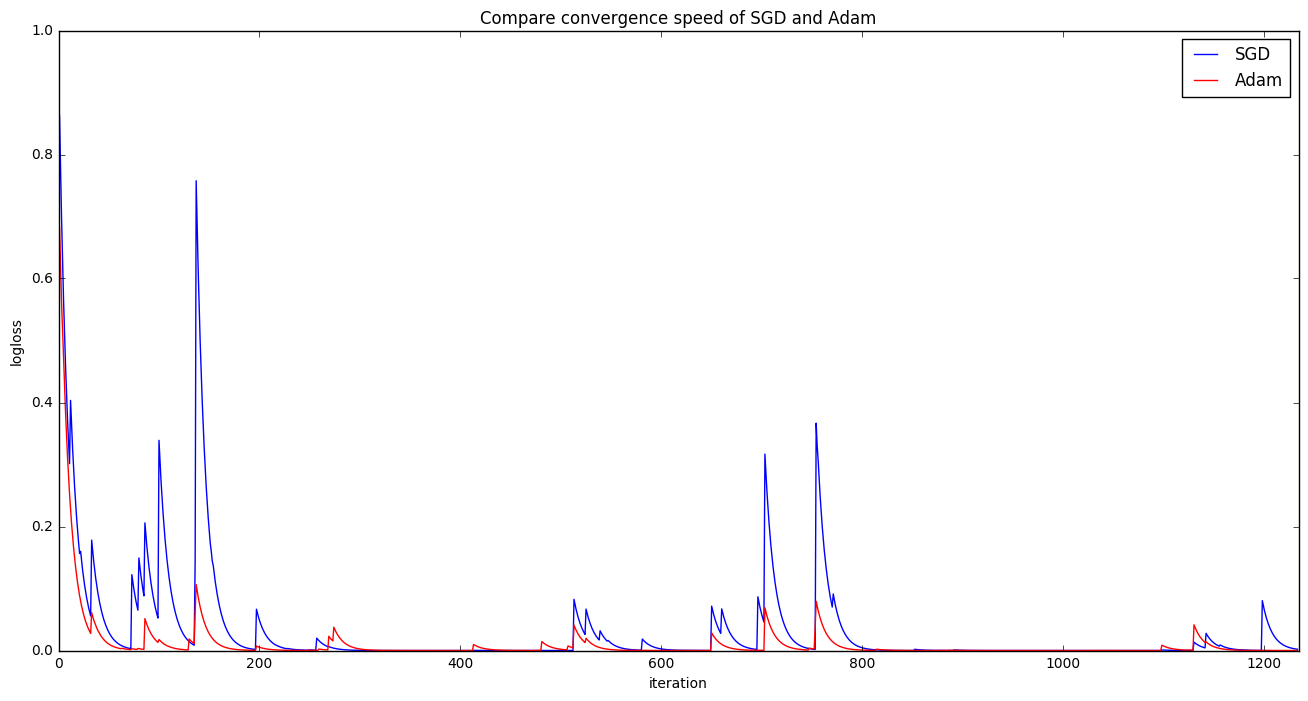

In [52]:
fig, ax = plt.subplots(1, figsize=(16, 8))

ax.set_title('Compare convergence speed of SGD and Adam')

Q_1sm = ExpSmooth(Q_1, 0.9)
Q_2sm = ExpSmooth(Q_2, 0.9)
ax.axis([0, len(Q_1sm), 0, 1])

ax.plot(range(len(Q_1sm)), Q_1sm, label='SGD')
ax.plot(range(len(Q_2sm)), Q_2sm, c='red', label='Adam')

ax.set_xlabel('iteration')
ax.set_ylabel('logloss')

plt.legend()
plt.show()

Как видно, оба метода сходятся достаточно хорошо и быстро, однако $Adam$ немного быстрее.